In [126]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pandas as pd
import math
import seaborn as sns

# Import de la base et création du réseau

In [34]:
df = pd.read_stata('TRADHIST_v4.dta')

In [63]:
#On filtre la période 1962-1975
df["year"] = df["year"].apply(int)
df = df[df['year'].isin(range(1962, 1976))]

#On filtre les lignes qui indiquent bien des pays d'arrivée et de départ
print(["Nombres de lignes", len(df)])
print(["Valeurs manquantes pour pays de départ", sum(df["iso_o"] == "")])
print(["Valeurs manquantes pour pays d'arrivée", sum(df["iso_d"] == "")])

df = df[df["iso_d"] != ""]
df = df[df["iso_o"] != ""]
print(["Nombres de lignes", len(df)])

#On filtre les fluxs pour ne retenir que ceux pour lesquels le flox est renseigné
print(["Valeurs manquantes pour le flux", sum(df["FLOW"].isna())])
df = df[df["FLOW"].isna() == False]
print(["Nombres de lignes", len(df)])

['Nombres de lignes', 399963]
['Valeurs manquantes pour pays de départ', 0]
["Valeurs manquantes pour pays d'arrivée", 0]
['Nombres de lignes', 399963]
['Valeurs manquantes pour le flux', 98760]
['Nombres de lignes', 301203]


In [119]:
#On crée un network par an 
liste_networks = []
for year in tqdm.tqdm(range(1962, 1976)):
    locals()["group"+ str(year)] = df[df["year"] == year]
    locals()["net"+ str(year)] = nx.from_pandas_edgelist(locals()["group"+ str(year)], 'iso_o', 'iso_d', edge_attr= 'FLOW')
    liste_networks.append(locals()["net"+ str(year)])

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.13it/s]


# I - Statistiques descriptives à l'échelle du réseau

## Réseau non orienté 

In [133]:
print([len(G.nodes) for nodes in liste_networks])

[181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181]


On a toujours exactement 181 noeuds dans le réseau, peu importe la période considérée. 

### Mesures non pondérées

### Densité

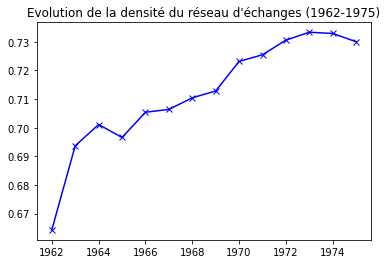

In [156]:
plt.plot(range(1962, 1976), [nx.density(G) for G in liste_networks],  "-xb")
plt.title("Evolution de la densité du réseau d'échanges (1962-1975)")
plt.show()

http://www.cepii.fr/pdf_pub/wp/2013/wp2013-24.pdf
D'après le CEPII (utilisant la base BACI), 


*The trade network is characterized by high dimensionality and strong heterogeneity. The
22002 existing links in 2007 correspond to a density of the network of 0.7 (i.e the ratio between the number of “realized” links and the number of maximum links possible),
indicating that taking two countries at random the probability of an existing trade link
among them is of 70%.*

Même ordre de grandeur ici (https://core.ac.uk/download/pdf/54926841.pdf)

Ici, on doit avoir une densité du réseau artificiellement augmentée par le fait qu'on ne considère que 181 pays parmi les 195 ? 

### Diamètre

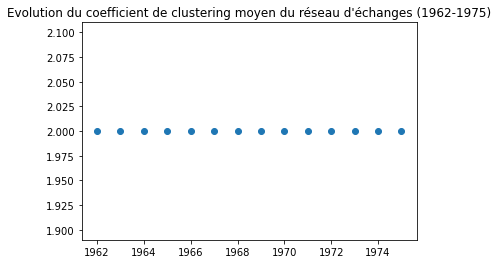

In [152]:
plt.scatter(range(1962, 1976), [nx.diameter(G) for G in liste_networks])
plt.title("Evolution du diamètre du réseau d'échanges  (1962-1975)")
plt.show()

### Mesures pondérées

### Coefficient de clustering moyen

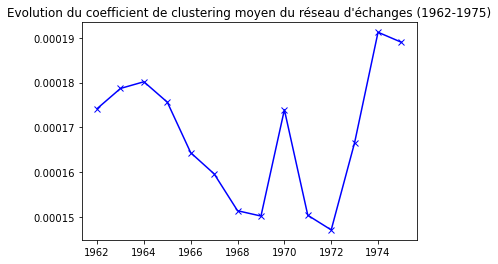

In [157]:
plt.plot(range(1962, 1976), [nx.average_clustering(G, weight= "FLOW") for G in liste_networks],  "-xb")
plt.title("Evolution du coefficient de clustering moyen du réseau d'échanges (1962-1975)")
plt.show()

### Average shortest path

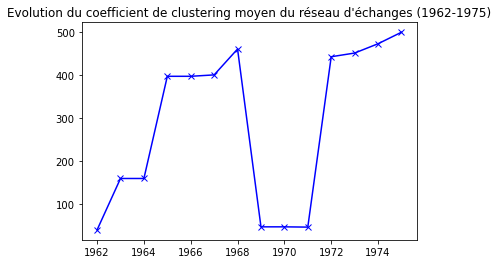

In [155]:
plt.plot(range(1962, 1976), [nx.average_shortest_path_length(G, weight= "FLOW") for G in liste_networks], "-xb")
plt.title("Evolution du coefficient de clustering moyen du réseau d'échanges (1962-1975)")
plt.show()

### Degree centrality

In [241]:
 A = pd.DataFrame( nx.degree_centrality(net1962).keys(),nx.degree_centrality(net1962).values())
A['deg_centrality'] = A.index.values

In [190]:
L = [nx.degree_centrality(node) for node in net1962.nodes()]



AttributeError: 'str' object has no attribute 'degree'

In [82]:
def logBinning(degreeList,nbin):
    kmin=min(degreeList)
    kmax=max(degreeList)
    logBins = np.logspace(np.log10(kmin), np.log10(kmax),num=nbin)
    logBinDensity, binedges = np.histogram(degreeList, bins=logBins, density=True)
    logBins = np.delete(logBins, -1)

    return logBinDensity, logBins

In [65]:
#Pour construire le réseau n°2, on filtre les fluxs pour ne retenir que ceux pour lesquels le PIb d'origine est renseigné
sum(df["GDP_o"].isna())

36016

# II - Statistiques descriptives à l'échelles des noeuds

# III - Etude des communautés à l'intérieur du réseau